In [1]:
import sys
import os
import re
import numpy as np
import xarray as xr
import xesmf as xe
import seaborn as sns
from glob import glob
import cftime

sys.path.append('/Users/ignasi/Desktop/Oceanography/IEO/projects/stratification_CMIP6')
from stratification_functions import get_model_folders, cftime_to_numpy

base_dir = "/Volumes/Thalassa/CMIP6_SHDR/"
selected_models=get_model_folders(base_dir, year=1990)
timei='1994-01'
timef='2014-12'


In [2]:

selected_models=selected_models[1:-1]


In [3]:
D=([])
a1=([])
b3=([])

for model_name in selected_models:
    model_path = os.path.join(base_dir, model_name)
    model_files = [os.path.join(model_path, f) for f in os.listdir(model_path) if f.endswith(".nc")]
    
    # Cargar múltiples archivos del modelo
    model_ds = xr.open_mfdataset(model_files, concat_dim='time', combine='nested')
    
    if isinstance(model_ds.time.values[0], cftime.DatetimeNoLeap):
        model_ds['time'] = [cftime_to_numpy(t) for t in model_ds['time'].values]
    
    if len(np.unique(model_ds['time'])) < len(model_ds['time']):
        print(model_name)
        _, index = np.unique(model_ds['time'], return_index=True)
        unique_mask = np.isin(np.arange(len(model_ds['time'])), index)
        model_ds = model_ds.isel(time=unique_mask)
    
    model_ds=model_ds.sortby('time')
    
    # Ajustar longitudes si están en el rango 0 a 360
    if "lon" in model_ds.coords:
        lon_min = model_ds.lon.min().values
        if lon_min > 0:  # Ya está en -180 a 180
            model_ds = model_ds.assign_coords(lon=((model_ds.lon + 180) % 360) - 180)
    else:
        raise ValueError(f"No se encontró la coordenada 'lon' en el dataset de {model_name}")
    
    # Detectar dimensiones espaciales: lat/lon o j/i
    if {"lat", "lon"}.issubset(model_ds.dims):  # Si tiene lat/lon
        #print(f"{model_name}: Usando dimensiones lat/lon.")
        spatial_dims = ("lat", "lon")
    elif {"j", "i"}.issubset(model_ds.dims):  # Si tiene j/i
        #print(f"{model_name}: Usando dimensiones j/i.")
        spatial_dims = ("j", "i")
    else:
        raise ValueError(f"No se encontraron dimensiones espaciales válidas en {model_name}.")
    
    # Seleccionar la región de interés
    region = model_ds.where(
        (model_ds.lat > 43) & (model_ds.lat < 46) & 
        (model_ds.lon > -6) & (model_ds.lon < -3), 
        drop=True
    )
    
    # Calcular la media mensual del parámetro 'a1' en la región
    D.append(region.load().sel(time=slice(timei,timef)).sel(param='D1').shdr.mean(dim=spatial_dims).groupby('time.month').mean('time'))
    a1.append(region.load().sel(time=slice(timei,timef)).sel(param='a1').shdr.mean(dim=spatial_dims).groupby('time.month').mean('time'))
    b3.append(region.load().sel(time=slice(timei,timef)).sel(param='b3').shdr.mean(dim=spatial_dims).groupby('time.month').mean('time'))
    
    # Opcional: Guardar o imprimir resultados
    #print(f"{model_name}: Media mensual calculada.")

NESM3
ACCESS-CM2


In [4]:
D_models=xr.concat(D,dim='models')
a1_models=xr.concat(a1,dim='models')
b3_models=xr.concat(b3,dim='models')

In [5]:
stats = {}
for param_name, param_data in {"D": D_models, "a1": a1_models, "b3": b3_models}.items():
    stats[param_name] = {
        "mean": param_data.mean(dim="models"),
        "std": param_data.std(dim="models"),
        "iqr": param_data.quantile(0.75, dim="models") - param_data.quantile(0.25, dim="models")
    }

In [6]:
# Data from CORA
cora_path='/Volumes/Thalassa/CORA_SHDR/*.nc'
cora_files = sorted(glob(cora_path))
cora_ds = xr.open_mfdataset(cora_files, concat_dim='time', combine='nested')

cora_region = cora_ds.where(
        (cora_ds.lat > 43) & (cora_ds.lat < 46) & 
        (cora_ds.lon > -6) & (cora_ds.lon < -3), 
        drop=True)

spatial_dims=('latitude','longitude')

D_cora=cora_region.load().sel(time=slice(timei,timef)).sel(param='D1').shdr.mean(dim=spatial_dims).groupby('time.month').mean('time')
a1_cora=cora_region.load().sel(time=slice(timei,timef)).sel(param='a1').shdr.mean(dim=spatial_dims).groupby('time.month').mean('time')
b3_cora=cora_region.load().sel(time=slice(timei,timef)).sel(param='b3').shdr.mean(dim=spatial_dims).groupby('time.month').mean('time')

In [7]:
cora_data={}
for param_name, param_data in {'D':D_cora, 'a1':a1_cora, 'b3':b3_cora}.items():
    cora_data[param_name]=param_data


In [8]:
s7=xr.open_dataset('/Users/ignasi/Desktop/Oceanography/IEO/projects/stratification_CMIP6/Radcan/ds_S7.nc')
s4=xr.open_dataset('/Users/ignasi/Desktop/Oceanography/IEO/projects/stratification_CMIP6/Radcan/ds_S4.nc')

a1S7=s7.a1.groupby('time.month').mean('time')
b3S7=s7.b3.groupby('time.month').mean('time')
DS7=s7.D.groupby('time.month').mean('time')


a1S4=s4.a1.groupby('time.month').mean('time')
b3S4=s4.b3.groupby('time.month').mean('time')
DS4=s4.D.groupby('time.month').mean('time')


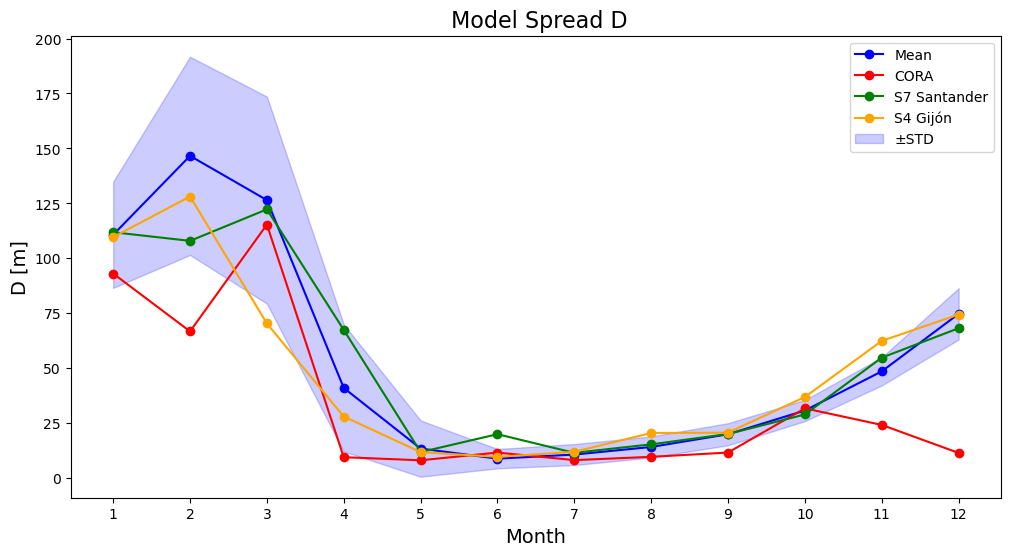

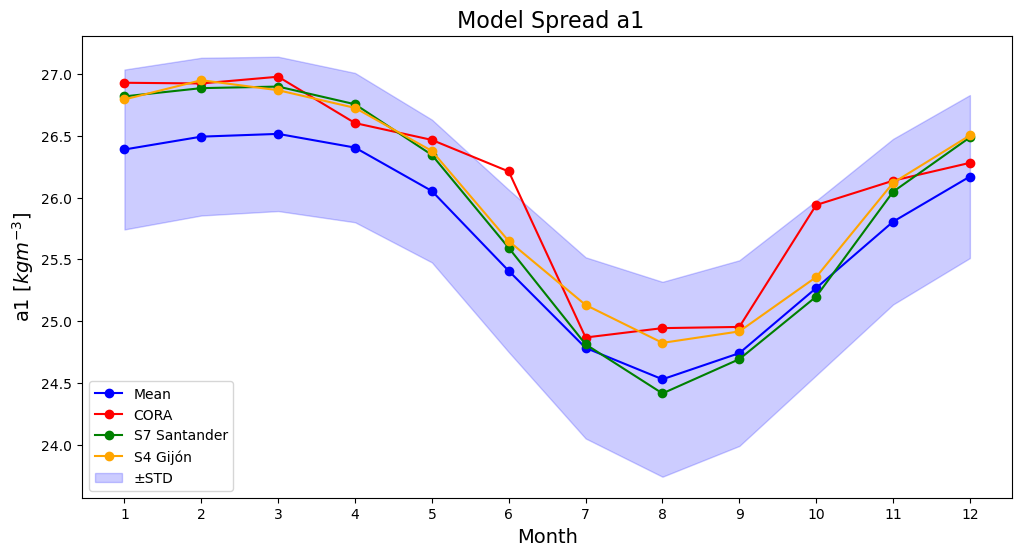

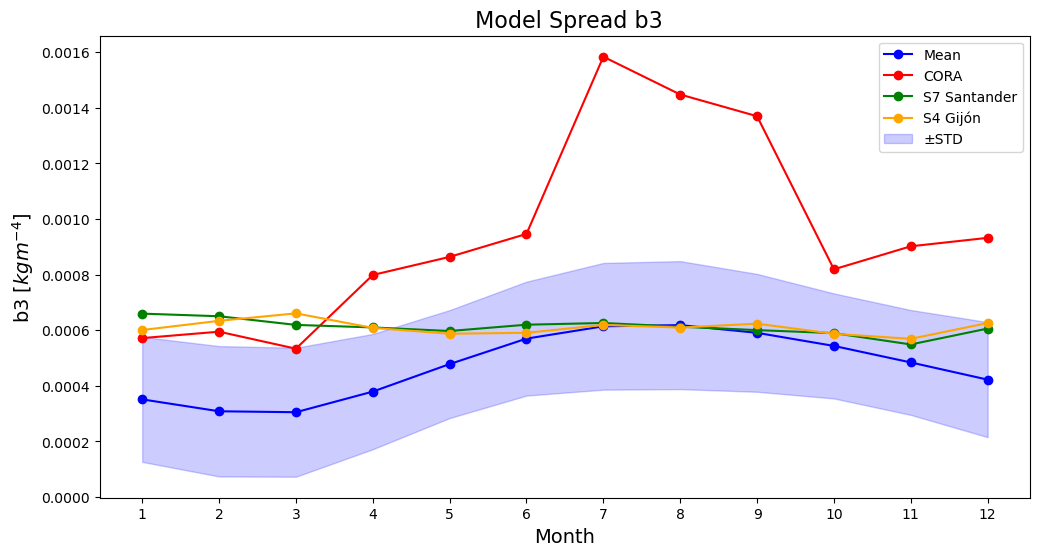

In [10]:
import matplotlib.pyplot as plt

months = np.arange(1, 13)
units=['[m]',r'[$kg m^{-3}$]',r'[$kg m^{-4}$]']
j=0
for param_name, param_stats in stats.items():
    
    plt.figure(figsize=(12, 6))
    plt.plot(months, param_stats["mean"], label="Mean", color="b", marker="o")
    plt.plot(months, cora_data[param_name], label='CORA',color='r',marker="o")
    s7_param=s7[param_name].groupby('time.month').mean('time')
    s4_param=s4[param_name].groupby('time.month').mean('time')
    plt.plot(months, s7_param, label='S7 Santander',color='g',marker="o")
    plt.plot(months, s4_param, label='S4 Gijón',color='orange',marker="o")
    
    
    plt.fill_between(
        months,
        param_stats["mean"] - param_stats["std"],
        param_stats["mean"] + param_stats["std"],
        color="blue", alpha=0.2, label="±STD"
    )
    plt.title(f" Model Spread {param_name}", fontsize=16)
    plt.xlabel("Month", fontsize=14)
    plt.ylabel(f"{param_name} {units[j]}", fontsize=14)
    plt.legend()
    plt.xticks(ticks=months)
    plt.savefig('/Users/ignasi/Desktop/Oceanography/IEO/projects/stratification_CMIP6/Radcan/'+param_name+'.png',dpi=300)
    plt.show()
    j+=1
    

In [12]:
s7b3=s7['b3'].groupby('time.month').mean('time')
s7a1=s7['a1'].groupby('time.month').mean('time')
s7D=s7['D'].groupby('time.month').mean('time')

s4b3=s4['b3'].groupby('time.month').mean('time')
s4a1=s4['a1'].groupby('time.month').mean('time')
s4D=s4['D'].groupby('time.month').mean('time')


D_models2=xr.concat((D_models.drop('param'),cora_data['D'].drop('param'),s7D,s4D),dim='models')
a1_models2=xr.concat((a1_models.drop('param'),cora_data['a1'].drop('param'),s7a1,s4a1),dim='models')
b3_models2=xr.concat((b3_models.drop('param'),cora_data['b3'].drop('param'),s7b3,s4b3),dim='models')




<xarray.DataArray 'shdr' (models: 17, month: 12)>
array([[115.66123081, 177.52301989, 190.46648091,  94.67477952,
          8.20685276,   7.00869158,   8.18760936,  10.6956751 ,
         18.07212419,  32.75768631,  52.12665968,  75.12293347],
       [130.60132356, 205.75918609, 186.9469919 ,  30.48006222,
          2.63728676,   5.64626047,   8.29213213,  11.59657927,
         16.21933744,  25.28406735,  44.1699462 ,  70.98022391],
       [141.45678274, 197.57145591, 185.35395884,  27.16714196,
          5.58500735,   8.58599833,  11.11382995,  14.07245193,
         18.33781819,  27.47568182,  46.66861036,  77.70100759],
       [129.30095151, 200.03342305, 155.1256461 ,   2.18619093,
          1.22478705,   2.00580562,   4.0123681 ,   9.35377289,
         18.27493805,  31.1958734 ,  54.40018979,  88.63809626],
       [ 76.05521601,  79.96550534,  80.2180038 ,  71.47640081,
         43.220095  ,   9.49295167,   9.81102894,  14.5433094 ,
         21.22134408,  30.86132934,  44.15476777,  63.27051229],
       [ 78.9236423 ,  98.40813242,  78.34454765,  15.62737801,
          2.40280894,   5.02096182,   7.81034291,  10.87307367,
         13.90152636,  21.40380447,  35.106865  ,  56.66349493],
       [116.35971775, 167.48850369, 162.88573176,  23.32458542,
         13.43251082,  15.54656616,  19.17154643,  21.56391179,
...
         11.23586696,  11.42773723,  12.07480799,  15.42874302,
         20.9158496 ,  28.81607562,  45.16550477,  68.06504415],
       [117.51915556, 169.87417433, 141.43963808,  21.1761892 ,
         14.7578046 ,  18.06269933,  20.84142907,  24.70220381,
         30.10335909,  37.30554602,  50.01866878,  80.06319187],
       [ 74.30487867,  77.65178588,  77.56351154,  66.95390313,
         42.47274693,   7.80307558,  10.59385518,  15.20315619,
         22.71652676,  33.08530391,  47.63046238,  61.48852919],
       [133.80921251, 168.40990594,  95.63119345,  18.57759188,
         10.90948551,  11.2357266 ,  11.96294403,  15.54810911,
         20.8042388 ,  32.88944333,  57.80199768,  86.17603772],
       [ 93.09548764,  66.78502218, 115.36004532,   9.55919372,
          8.15835401,  11.67305316,   8.23304846,   9.7273854 ,
         11.67738617,  31.78026087,  24.23864715,  11.50444035],
       [111.88736842, 107.95894737, 122.28423077,  67.465     ,
         11.88565217,  20.02758621,  11.54103448,  15.4096    ,
         20.10375   ,  29.01043478,  54.83789474,  68.22421053],
       [109.67333333, 128.13285714,  70.38444444,  28.05333333,
         11.87285714,   9.70444444,  12.008     ,  20.57222222,
         20.7275    ,  36.94222222,  62.47666667,  74.44875   ]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: models

In [62]:
selected_models

['CanESM5',
 'EC-Earth3-Veg',
 'EC-Earth',
 'CMCC-CM2',
 'E3SM-1-1-ECA',
 'UKESM1-1',
 'SAM0-UNICON',
 'NESM3',
 'ACCESS-CM2',
 'MRI-ESM2',
 'MPI-ESM2',
 'FIO-ESM2',
 'E3SM-1-0',
 'CAMS-CSM1']

In [64]:
names=selected_models
names

['CanESM5',
 'EC-Earth3-Veg',
 'EC-Earth',
 'CMCC-CM2',
 'E3SM-1-1-ECA',
 'UKESM1-1',
 'SAM0-UNICON',
 'NESM3',
 'ACCESS-CM2',
 'MRI-ESM2',
 'MPI-ESM2',
 'FIO-ESM2',
 'E3SM-1-0',
 'CAMS-CSM1']

In [65]:
names.append('CORA')
names.append('S7')
names.append('G4')

In [66]:
names

['CanESM5',
 'EC-Earth3-Veg',
 'EC-Earth',
 'CMCC-CM2',
 'E3SM-1-1-ECA',
 'UKESM1-1',
 'SAM0-UNICON',
 'NESM3',
 'ACCESS-CM2',
 'MRI-ESM2',
 'MPI-ESM2',
 'FIO-ESM2',
 'E3SM-1-0',
 'CAMS-CSM1',
 'CORA',
 'S7',
 'G4']

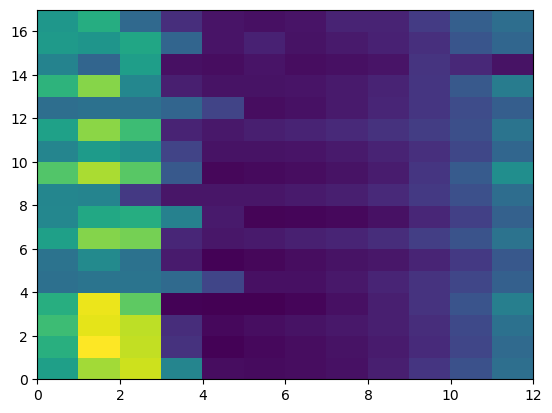

In [67]:
plt.pcolor(D_models2)

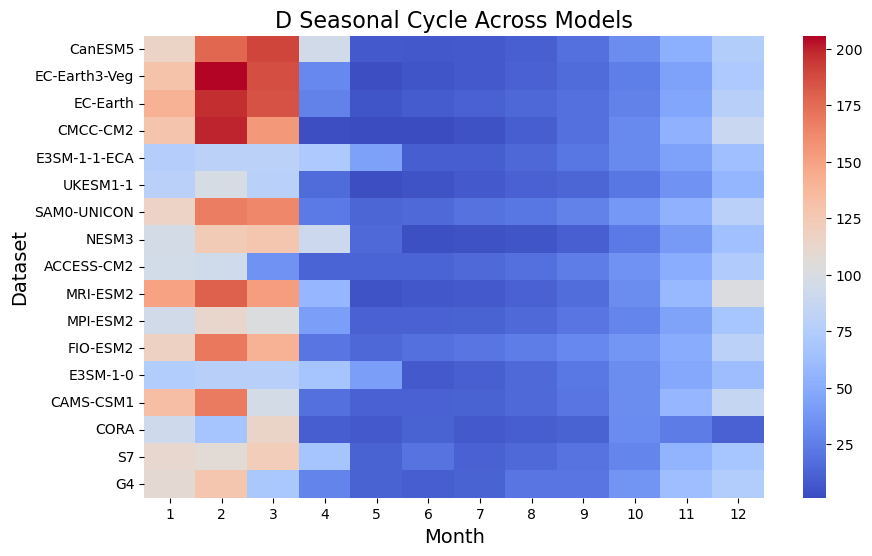

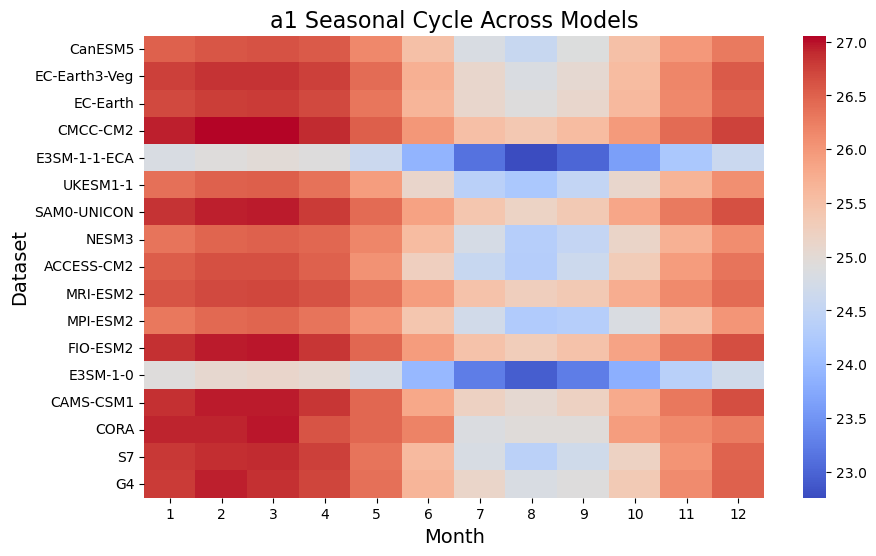

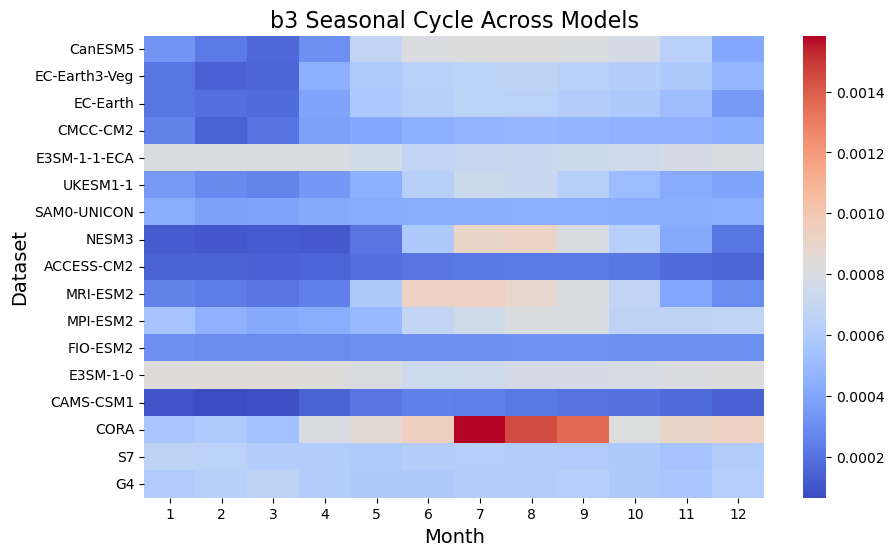

In [80]:
for param_name, param_data in {"D": D_models2, "a1": a1_models2, "b3": b3_models2}.items():
    plt.figure(figsize=(10, 6))
    sns.heatmap(param_data, cmap="coolwarm", cbar=True, annot=False)
    #plt.contourf(param_data)
    plt.title(f"{param_name} Seasonal Cycle Across Models", fontsize=16)
    plt.xlabel("Month", fontsize=14)
    plt.ylabel("Dataset", fontsize=14)
    plt.yticks(ticks=np.arange(len(names))+0.5, labels=names, rotation=0)
    plt.xticks(ticks=np.arange(0,12)+0.5, labels=np.arange(1,13))
    plt.savefig('/Users/ignasi/Desktop/Oceanography/IEO/projects/stratification_CMIP6/Radcan/'+param_name+'all_models.png',dpi=300)
    plt.show()


In [85]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.signal import welch

D_trend=([])
a1_trend=([])
b3_trend=([])


for model_name in selected_models:
    model_path = os.path.join(base_dir, model_name)
    model_files = [os.path.join(model_path, f) for f in os.listdir(model_path) if f.endswith(".nc")]
    
    # Cargar múltiples archivos del modelo
    model_ds = xr.open_mfdataset(model_files, concat_dim='time', combine='nested')
    
    if isinstance(model_ds.time.values[0], cftime.DatetimeNoLeap):
        model_ds['time'] = [cftime_to_numpy(t) for t in model_ds['time'].values]
    
    if len(np.unique(model_ds['time'])) < len(model_ds['time']):
        print(model_name)
        _, index = np.unique(model_ds['time'], return_index=True)
        unique_mask = np.isin(np.arange(len(model_ds['time'])), index)
        model_ds = model_ds.isel(time=unique_mask)
    
    model_ds=model_ds.sortby('time')
    
    # Ajustar longitudes si están en el rango 0 a 360
    if "lon" in model_ds.coords:
        lon_min = model_ds.lon.min().values
        if lon_min > 0:  # Ya está en -180 a 180
            model_ds = model_ds.assign_coords(lon=((model_ds.lon + 180) % 360) - 180)
    else:
        raise ValueError(f"No se encontró la coordenada 'lon' en el dataset de {model_name}")
    
    # Detectar dimensiones espaciales: lat/lon o j/i
    if {"lat", "lon"}.issubset(model_ds.dims):  # Si tiene lat/lon
        #print(f"{model_name}: Usando dimensiones lat/lon.")
        spatial_dims = ("lat", "lon")
    elif {"j", "i"}.issubset(model_ds.dims):  # Si tiene j/i
        #print(f"{model_name}: Usando dimensiones j/i.")
        spatial_dims = ("j", "i")
    else:
        raise ValueError(f"No se encontraron dimensiones espaciales válidas en {model_name}.")
    
    # Seleccionar la región de interés
    region = model_ds.where(
        (model_ds.lat > 43) & (model_ds.lat < 46) & 
        (model_ds.lon > -6) & (model_ds.lon < -3), 
        drop=True
    )
    
    rolling_window = 7 * 12
    # Calcular la media mensual del parámetro 'a1' en la región
    D_trend.append(region.load().sel(param='D1').shdr.mean(dim=spatial_dims).rolling(time=rolling_window, center=True,min_periods=1).mean())
    a1_trend.append(region.load().sel(param='a1').shdr.mean(dim=spatial_dims).rolling(time=rolling_window, center=True,min_periods=1).mean())
    b3_trend.append(region.load().sel(param='b3').shdr.mean(dim=spatial_dims).rolling(time=rolling_window, center=True,min_periods=1).mean())
    

NESM3
ACCESS-CM2


In [93]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

base_dir = "/Volumes/Thalassa/CMIP6_SSP585_SHDR/"
selected_models_ssp585=get_model_folders(base_dir, year=2020)
del selected_models_ssp585[6]

D_trend=([])
a1_trend=([])
b3_trend=([])

for model_name in selected_models_ssp585:
    
        
    model_path = os.path.join(base_dir, model_name)
    model_files = [os.path.join(model_path, f) for f in os.listdir(model_path) if f.endswith(".nc")]

    # Cargar múltiples archivos del modelo
    model_ds = xr.open_mfdataset(model_files, concat_dim='time', combine='nested')

    if isinstance(model_ds.time.values[0], cftime.DatetimeNoLeap):
        model_ds['time'] = [cftime_to_numpy(t) for t in model_ds['time'].values]

    #if model_ds['time'].dtype == 'O':
        #model_ds=model_ds.assign_coords(time=pd.to_datetime(model_ds['time'].values))

    if isinstance(model_ds.indexes['time'][0], cftime.Datetime360Day):
        model_ds = model_ds.assign_coords(time=model_ds.indexes['time'].to_datetimeindex())

    if len(np.unique(model_ds['time'])) < len(model_ds['time']):
        _, index = np.unique(model_ds['time'], return_index=True)
        unique_mask = np.isin(np.arange(len(model_ds['time'])), index)
        model_ds = model_ds.isel(time=unique_mask)


    model_ds=model_ds.sortby('time')

    # Ajustar longitudes si están en el rango 0 a 360
    if "lon" in model_ds.coords:
        lon_min = model_ds.lon.min().values
        if lon_min > 0:  # Ya está en -180 a 180
            model_ds = model_ds.assign_coords(lon=((model_ds.lon + 180) % 360) - 180)
    else:
        raise ValueError(f"No se encontró la coordenada 'lon' en el dataset de {model_name}")

    # Detectar dimensiones espaciales: lat/lon o j/i
    if {"lat", "lon"}.issubset(model_ds.dims):  # Si tiene lat/lon
        #print(f"{model_name}: Usando dimensiones lat/lon.")
        spatial_dims = ("lat", "lon")
    elif {"j", "i"}.issubset(model_ds.dims):  # Si tiene j/i
        #print(f"{model_name}: Usando dimensiones j/i.")
        spatial_dims = ("j", "i")
    else:
        raise ValueError(f"No se encontraron dimensiones espaciales válidas en {model_name}.")

    # Seleccionar la región de interés
    region = model_ds.where(
        (model_ds.lat > 43) & (model_ds.lat < 46) & 
        (model_ds.lon > -6) & (model_ds.lon < -3), 
        drop=True
    )
    
    rolling_window = 7*12
    # Calcular la media mensual del parámetro 'a1' en la región
    D=(region.load().sel(param='D1').shdr.mean(dim=spatial_dims)).rolling(time=rolling_window, center=True).mean().groupby('time.year').mean('time')
    a1=(region.load().sel(param='a1').shdr.mean(dim=spatial_dims)).rolling(time=rolling_window, center=True).mean().groupby('time.year').mean('time')
    b3=(region.load().sel(param='b3').shdr.mean(dim=spatial_dims)).rolling(time=rolling_window, center=True).mean().groupby('time.year').mean('time')
    
    D_trend.append(D)
    a1_trend.append(a1)
    b3_trend.append(b3)


In [109]:
D_100=xr.concat(D_trend,dim='model').mean('model')
a1_100=xr.concat(a1_trend,dim='model').mean('model')
b3_100=xr.concat(b3_trend,dim='model').mean('model')

D_100_std=xr.concat(D_trend,dim='model').std('model')
a1_100_std=xr.concat(a1_trend,dim='model').std('model')
b3_100_std=xr.concat(b3_trend,dim='model').std('model')

datetime64_array = np.array([np.datetime64(f"{year}-01-01") for year in D_100.year.values])


In [110]:
D_100=D_100.assign_coords(year=datetime64_array)
a1_100=a1_100.assign_coords(year=datetime64_array)
b3_100=b3_100.assign_coords(year=datetime64_array)

D_100_std=D_100_std.assign_coords(year=datetime64_array)
a1_100_std=a1_100_std.assign_coords(year=datetime64_array)
b3_100_std=b3_100_std.assign_coords(year=datetime64_array)

In [62]:
selected_models_ssp585

['BCC-CSM2',
 'CAMS-CSM1',
 'CanESM5',
 'E3SM-1-0',
 'EC-Earth',
 'GFDL-CM4',
 'MIROC6',
 'NCAR']

/Users/ignasi/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


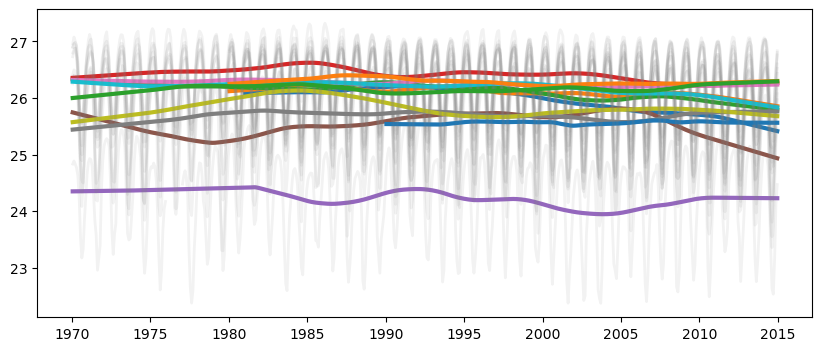

In [118]:




plt.figure(figsize=(10, 4))

base_dir = "/Volumes/Thalassa/CMIP6_SHDR/"

for model_name in selected_models:
    
        
    model_path = os.path.join(base_dir, model_name)
    model_files = [os.path.join(model_path, f) for f in os.listdir(model_path) if f.endswith(".nc")]

    # Cargar múltiples archivos del modelo
    model_ds = xr.open_mfdataset(model_files, concat_dim='time', combine='nested')

    if isinstance(model_ds.time.values[0], cftime.DatetimeNoLeap):
        model_ds['time'] = [cftime_to_numpy(t) for t in model_ds['time'].values]

    #if model_ds['time'].dtype == 'O':
        #model_ds=model_ds.assign_coords(time=pd.to_datetime(model_ds['time'].values))

    if isinstance(model_ds.indexes['time'][0], cftime.Datetime360Day):
        model_ds = model_ds.assign_coords(time=model_ds.indexes['time'].to_datetimeindex())

    if len(np.unique(model_ds['time'])) < len(model_ds['time']):
        _, index = np.unique(model_ds['time'], return_index=True)
        unique_mask = np.isin(np.arange(len(model_ds['time'])), index)
        model_ds = model_ds.isel(time=unique_mask)


    model_ds=model_ds.sortby('time')

    # Ajustar longitudes si están en el rango 0 a 360
    if "lon" in model_ds.coords:
        lon_min = model_ds.lon.min().values
        if lon_min > 0:  # Ya está en -180 a 180
            model_ds = model_ds.assign_coords(lon=((model_ds.lon + 180) % 360) - 180)
    else:
        raise ValueError(f"No se encontró la coordenada 'lon' en el dataset de {model_name}")

    # Detectar dimensiones espaciales: lat/lon o j/i
    if {"lat", "lon"}.issubset(model_ds.dims):  # Si tiene lat/lon
        #print(f"{model_name}: Usando dimensiones lat/lon.")
        spatial_dims = ("lat", "lon")
    elif {"j", "i"}.issubset(model_ds.dims):  # Si tiene j/i
        #print(f"{model_name}: Usando dimensiones j/i.")
        spatial_dims = ("j", "i")
    else:
        raise ValueError(f"No se encontraron dimensiones espaciales válidas en {model_name}.")

    # Seleccionar la región de interés
    region = model_ds.where(
        (model_ds.lat > 43) & (model_ds.lat < 46) & 
        (model_ds.lon > -6) & (model_ds.lon < -3), 
        drop=True
    )

    rolling_window = 5*12
    # Calcular la media mensual del parámetro 'a1' en la región
    D=(region.load().sel(param='D1').shdr.mean(dim=spatial_dims))
    a1=(region.load().sel(param='a1').shdr.mean(dim=spatial_dims))
    b3=(region.load().sel(param='b3').shdr.mean(dim=spatial_dims))

    D_clim=D.groupby('time.month').mean()
    a1_clim=a1.groupby('time.month').mean()
    b3_clim=b3.groupby('time.month').mean()

    D_anom=D.groupby('time.month')-D_clim
    a1_anom=a1.groupby('time.month')-a1_clim
    b3_anom=b3.groupby('time.month')-b3_clim
    
    Dvar = a1.rolling(time=rolling_window, center=True).mean()#.groupby('time.year').mean('time')
    
    lowess_mean = lowess(Dvar.values, Dvar['time'].values, frac=0.1)
    lowess_interpolator = interp1d(lowess_mean[:, 0], lowess_mean[:, 1], kind="linear", fill_value="extrapolate")
    lowess_full = lowess_interpolator(Dvar.time)

    plt.plot(a1.time,a1,'-', linewidth=2, color='gray',alpha=0.1)
    plt.plot(Dvar.time,lowess_full,'-', linewidth=3)
'''
plt.plot(D_100.year,D_100,'--',linewidth=2, color='red', label='SSP585')
plt.fill_between(
        D_100.year.values,
        D_100 - D_100_std,
        D_100 + D_100_std,
        color="red", alpha=0.2, label="±STD")
    
plt.legend()    
'''
plt.savefig('/Users/ignasi/Desktop/Oceanography/IEO/projects/stratification_CMIP6/Radcan/a1_all_years_smooth.png',dpi=300)
   
    

In [31]:
del selected_models[12]

In [113]:
a1_100.year

<xarray.DataArray 'year' (year: 86)>
array(['2015-01-01T00:00:00.000000000', '2016-01-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000', '2020-01-01T00:00:00.000000000',
       '2021-01-01T00:00:00.000000000', '2022-01-01T00:00:00.000000000',
       '2023-01-01T00:00:00.000000000', '2024-01-01T00:00:00.000000000',
       '2025-01-01T00:00:00.000000000', '2026-01-01T00:00:00.000000000',
       '2027-01-01T00:00:00.000000000', '2028-01-01T00:00:00.000000000',
       '2029-01-01T00:00:00.000000000', '2030-01-01T00:00:00.000000000',
       '2031-01-01T00:00:00.000000000', '2032-01-01T00:00:00.000000000',
       '2033-01-01T00:00:00.000000000', '2034-01-01T00:00:00.000000000',
       '2035-01-01T00:00:00.000000000', '2036-01-01T00:00:00.000000000',
       '2037-01-01T00:00:00.000000000', '2038-01-01T00:00:00.000000000',
       '2039-01-01T00:00:00.000000000', '2040-01-01T00:00:00.000000000',
       '2041-01-01T00:00:00.000000000', '2042-01-01T00:00:00.000000000',
       '2043-01-01T00:00:00.000000000', '2044-01-01T00:00:00.000000000',
       '2045-01-01T00:00:00.000000000', '2046-01-01T00:00:00.000000000',
       '2047-01-01T00:00:00.000000000', '2048-01-01T00:00:00.000000000',
       '2049-01-01T00:00:00.000000000', '2050-01-01T00:00:00.000000000',
       '2051-01-01T00:00:00.000000000', '2052-01-01T00:00:00.000000000',
       '2053-01-01T00:00:00.000000000', '2054-01-01T00:00:00.000000000',
       '2055-01-01T00:00:00.000000000', '2056-01-01T00:00:00.000000000',
       '2057-01-01T00:00:00.000000000', '2058-01-01T00:00:00.000000000',
       '2059-01-01T00:00:00.000000000', '2060-01-01T00:00:00.000000000',
       '2061-01-01T00:00:00.000000000', '2062-01-01T00:00:00.000000000',
       '2063-01-01T00:00:00.000000000', '2064-01-01T00:00:00.000000000',
       '2065-01-01T00:00:00.000000000', '2066-01-01T00:00:00.000000000',
       '2067-01-01T00:00:00.000000000', '2068-01-01T00:00:00.000000000',
       '2069-01-01T00:00:00.000000000', '2070-01-01T00:00:00.000000000',
       '2071-01-01T00:00:00.000000000', '2072-01-01T00:00:00.000000000',
       '2073-01-01T00:00:00.000000000', '2074-01-01T00:00:00.000000000',
       '2075-01-01T00:00:00.000000000', '2076-01-01T00:00:00.000000000',
       '2077-01-01T00:00:00.000000000', '2078-01-01T00:00:00.000000000',
       '2079-01-01T00:00:00.000000000', '2080-01-01T00:00:00.000000000',
       '2081-01-01T00:00:00.000000000', '2082-01-01T00:00:00.000000000',
       '2083-01-01T00:00:00.000000000', '2084-01-01T00:00:00.000000000',
       '2085-01-01T00:00:00.000000000', '2086-01-01T00:00:00.000000000',
       '2087-01-01T00:00:00.000000000', '2088-01-01T00:00:00.000000000',
       '2089-01-01T00:00:00.000000000', '2090-01-01T00:00:00.000000000',
       '2091-01-01T00:00:00.000000000', '2092-01-01T00:00:00.000000000',
       '2093-01-01T00:00:00.000000000', '2094-01-01T00:00:00.000000000',
       '2095-01-01T00:00:00.000000000', '2096-01-01T00:00:00.000000000',
       '2097-01-01T00:00:00.000000000', '2098-01-01T00:00:00.000000000',
       '2099-01-01T00:00:00.000000000', '2100-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * year     (year) datetime64[ns] 2015-01-01 2016-01-01 ... 2100-01-01
    param    <U2 'a1'

In [12]:
data=model_ds
data = data.assign_coords(time=data.indexes['time'].to_datetimeindex())

/Users/ignasi/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


In [13]:
data

<xarray.Dataset>
Dimensions:  (time: 540, j: 330, i: 360, param: 8, lev: 50)
Coordinates:
  * lev      (lev) float64 0.5058 1.556 2.668 ... 1.152e+03 1.266e+03 1.387e+03
    lat      (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    lon      (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
  * time     (time) datetime64[ns] 1970-01-16 1970-02-16 ... 2014-12-16
  * j        (j) int32 0 1 2 3 4 5 6 7 8 ... 321 322 323 324 325 326 327 328 329
  * i        (i) int32 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
  * param    (param) object 'D1' 'b2' 'c2' 'b3' 'a2' 'a1' 'a3' 'em'
Data variables:
    shdr     (time, j, i, param) float64 dask.array<chunksize=(12, 330, 360, 8), meta=np.ndarray>
Attributes:
    n_lev_ratio:  50/75
    hor_res:      100 km
    info_url:     https://furtherinfo.es-doc.org/CMIP6.MOHC.UKESM1-1-LL.histo...

540
540


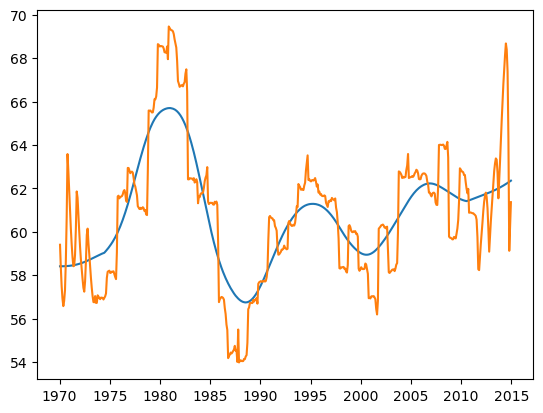

In [82]:
from scipy.interpolate import interp1d

lowess_mean = lowess(D_trend[6].values, D_trend[6]['time'].values, frac=0.2)

lowess_interpolator = interp1d(lowess_mean[:, 0], lowess_mean[:, 1], kind="linear", fill_value="extrapolate")
lowess_full = lowess_interpolator(D_trend[6].time)
print(len(lowess_mean))
print(len(D_trend[6].values))
plt.plot(D_trend[6].time,lowess_full)
plt.plot(D_trend[6].time,D_trend[6].values)

In [56]:
np.shape(lowess_mean)

(457, 2)

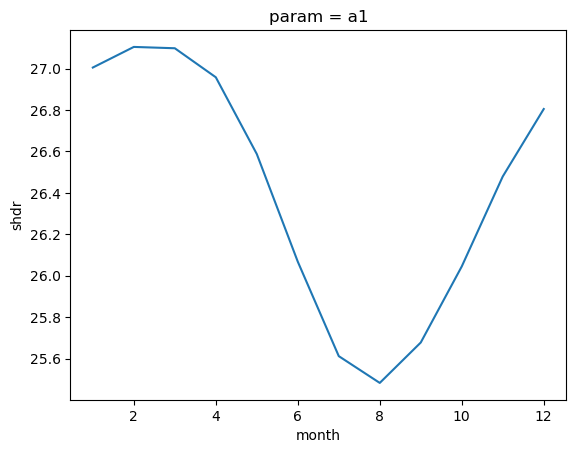

In [52]:
region.sel(param='a1').shdr.mean(('j','i')).groupby('time.month').mean('time').plot()